In [1]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc cm-super dvipng
!pip install pypandoc

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pandoc is already the newest version (2.9.2.1-3ubuntu2).
pandoc set to manually installed.
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre fonts-urw-base35 ghostscript
  libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35
  libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0 libsynctex2
  libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern
  pfb2t1c2pfb poppler-data preview-latex-style rake ruby ruby-net-telnet
  ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils
  teckit tex-common tex-gyre texlive-base texlive-binaries
  texlive-fonts-recommended texlive-latex-base texlive-latex-recommended
  texlive-pictures texlive-plain-generic tipa xfonts-en

If you want to upload your data:

In [2]:
# from google.colab import files
# uploaded = files.upload()

Take Data from Yahoo Finance:

In [3]:
!pip install yfinance --upgrade --no-cache-dir

In [4]:
import yfinance as yf

data = yf.download('AAPL MSFT AMZN NVDA GOOGL GOOG BRK-B META TSLA UNH JNJ \
XOM JPM LLY V PG AVGO HD MA CVX MRK ABBV PEP COST KO ADBE CSCO WMT PFE MCD TMO \
BAC CRM ACN CMCSA LIN ABT NFLX ORCL AMD DHR WFC DIS TXN PM COP CAT AMGN VZ UNP DX-Y.NYB', period="12mo")

[*********************100%%**********************]  51 of 51 completed


In [5]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica Neue"],
    "font.size": 28,
    })

In [21]:
# Load data
# prices = pd.read_excel("S&P 500 Stock Data.xlsx")
prices = data.iloc[:, 0:51] # change depending on number of stocks
returns = (np.array(prices.iloc[1:,:]) - np.array(prices.iloc[:-1,:])) / prices.iloc[:-1,:]
R = returns.iloc[150:200,:].to_numpy() # change between 150 and 200, and 200 and 250
R_test = returns.iloc[200:250,:].to_numpy()

In [22]:
prices.shape

(252, 51)

## Cumulative portfolio value over time

In [23]:
# Cumulative portfolo value over time
def portfolio_V(V_0, r):
    return V_0 * np.cumprod(1 + r)

# Check exact value vs approximation
T = 250
mu, sigma = .10/T, .05/np.sqrt(T)
r = mu + sigma * np.random.randn(T)
V0 = 10000
V = portfolio_V(V0, r)

print("V_T original = ", V[T-1])
print("V_T approx = ", (V0*(1 + np.sum(r))))

V_T original =  11719.72374605228
V_T approx =  11600.886750408916


## Portfolio return, risk and leverage

In [24]:
T, n = R.shape
T_test = R_test.shape[0]
w = np.ones(n)/n  # equal portfolio
r = R @ w # portfolio return time series

def annualize_return(r):
     return 250 * np.sum(r) / len(r)

def annualize_risk(r):
    return 250 * np.linalg.norm(r - np.mean(r) * np.ones(len(r)), 1) / len(r)
    # return np.sqrt(250) * np.std(r)

def leverage(w):
    return np.linalg.norm(w, 1)


pf_return = annualize_return(r)
pf_risk = annualize_risk(r)
pf_leverage = leverage(w)
print("Portfolio return = %.2f%%" % (pf_return * 100))
print("Portfolio risk = %.2f%%" % (pf_risk * 100))
print("Leverage = %.2f" % (pf_leverage))

Portfolio return = 34.83%
Portfolio risk = 145.44%
Leverage = 1.00


## Optimize for different trade-off parameters $\lambda$

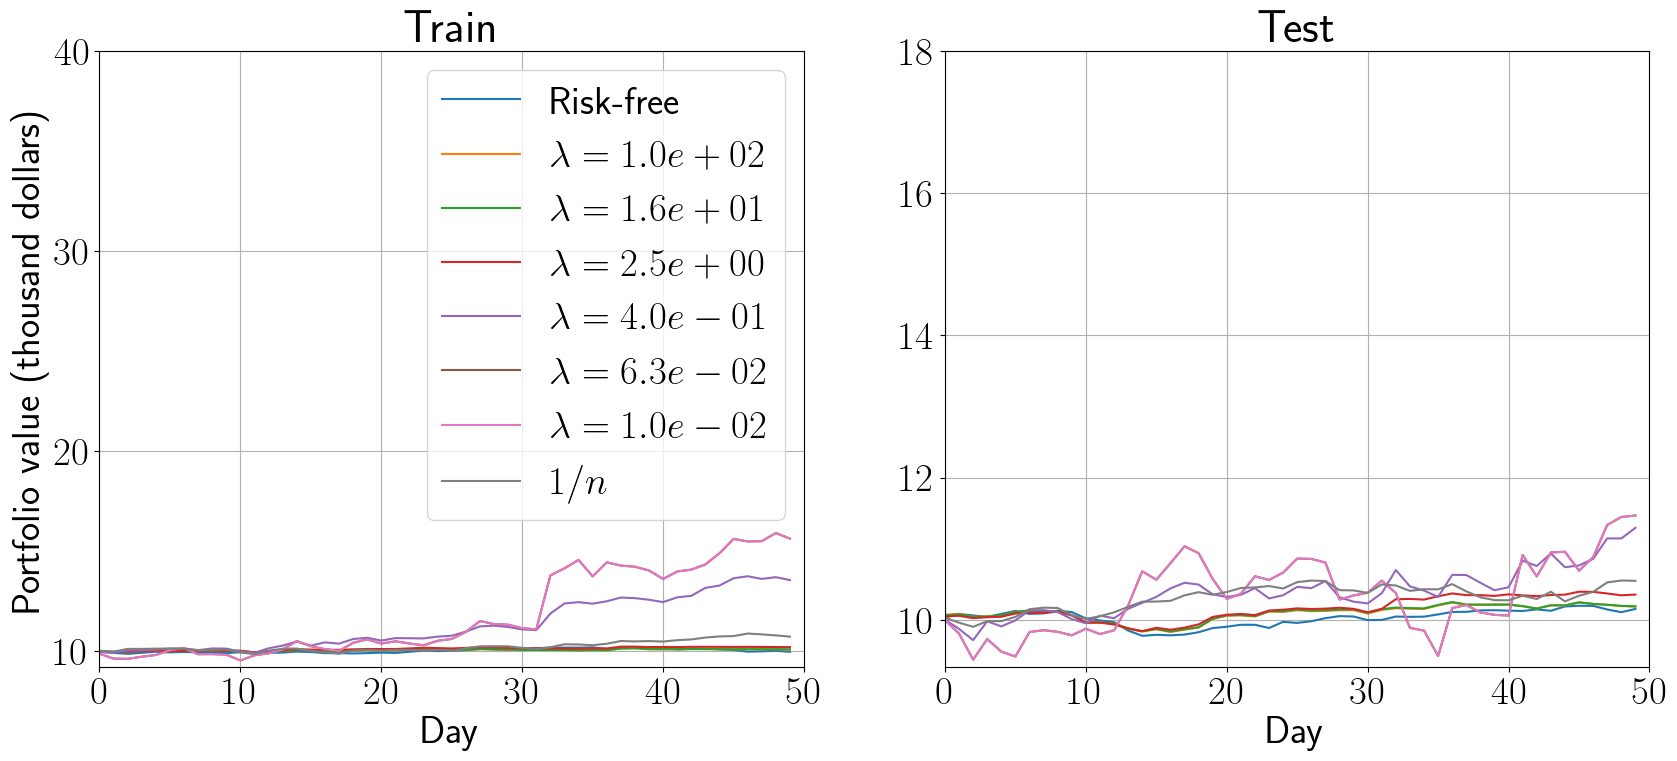

In [25]:
V0 = 10000
n_lam = 6
lam_vec = np.logspace(-2, 2, n_lam)[::-1] # change depending on how much risk you want to take (higher lambda = less risk)
n_assets = R.shape[1]
w_data = {}
results = []

def compute_results(w, r_train, r_test):
    return {'Train return': annualize_return(r_train),
            'Test return': annualize_return(r_test),
            'Train risk': annualize_risk(r_train),
            'Test risk': annualize_risk(r_test),
            # 'Leverage': leverage(w)
           }

fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Risk free
w = np.zeros(n_assets); w[20] = 1
r_train = R @ w  # Return time series
r_test = R_test @ w  # Test return time series
w_data.update({r"$\rm \mbox{Risk-free}$": w})  # append data
results.append(compute_results(w, r_train, r_test)) # append results
ax[0].plot(np.arange(T), portfolio_V(V0, r_train)/1000, label=r"Risk-free")
ax[1].plot(np.arange(R_test.shape[0]), portfolio_V(V0, r_test)/1000)

# Different lambdas

# Define optimization problem
w_var = cp.Variable(n_assets)
lam = cp.Parameter(nonneg=True)
mu = np.mean(R, axis=0)  # Average returns across time
ret = - mu @ w_var
risk = cp.norm(R @ w_var - ret * np.ones(T), 1)/T
objective = ret + lam * risk
constraints = [cp.sum(w_var) == 1, w_var >= 0]
problem = cp.Problem(cp.Minimize(objective), constraints)


for k in range(n_lam):
    lam.value = lam_vec[k]
    lam_string = r"$\lambda = {l:.1e}$".format(l=lam_vec[k])
    problem.solve()
    w = w_var.value
    r_train = R @ w  # Return time series
    r_test = R_test @ w  # Test return time series
    w_data.update({lam_string: w})
    results.append(compute_results(w, r_train, r_test))
    ax[0].plot(np.arange(T), portfolio_V(V0, r_train)/1000, label=lam_string)
    ax[1].plot(np.arange(R_test.shape[0]), portfolio_V(V0, r_test)/1000)

# Equal invesetment
w = np.ones(n_assets)/n_assets
r_train = R @ w  # Return time series
r_test = R_test @ w  # Test return time series
w_data.update({r"$1/n$": w})
results.append(compute_results(w, r_train, r_test))
ax[0].plot(np.arange(T), portfolio_V(V0, r_train)/1000, label=r"$1/n$")
ax[1].plot(np.arange(R_test.shape[0]), portfolio_V(V0, r_test)/1000)


# Create dataframe from results (round to 2 decimals)
df_results = pd.DataFrame(results).round(2)

# Complete plot
ax[0].set_ylabel("Portfolio value (thousand dollars)")
ax[0].set_title("Train")
ax[0].set_xlabel("Day")
ax[0].set_yticks([10, 20, 30, 40])
ax[0].set_xlim([0, T])
ax[0].grid()
ax[0].legend()
ax[1].set_xlabel("Day")
ax[1].set_title("Test")
ax[1].set_yticks([10, 12, 14, 16, 18])
ax[1].set_xlim([0, T_test])
ax[1].grid()
plt.savefig("total_portfolio.pdf")

In [26]:
w_df = pd.DataFrame(w_data).T.round(2)
w_df.columns = prices.columns
w_df

Adj Close                                            \
                            AAPL  ABBV   ABT   ACN  ADBE   AMD  AMGN  AMZN   
$\rm \mbox{Risk-free}$      0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
$\lambda = 1.0e+02$         0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.01   
$\lambda = 1.6e+01$         0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.01   
$\lambda = 2.5e+00$         0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.01   
$\lambda = 4.0e-01$         0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
$\lambda = 6.3e-02$         0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
$\lambda = 1.0e-02$         0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
$1/n$                       0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02   

                                    ...                                      \
                        AVGO   BAC  ...   TMO  TSLA   TXN   UNH   UNP     V   
$\rm \mbox{Risk-free}$  0.00  0.00  ...  0.00  0.00  0.00  0.00  0.00  0.00   
$\lambda = 1.0e+02$     0.00  0.00  ...  0.00  0.00  0.00  0.00  0.10  0.00   
$\lambda = 1.6e+01$     0.00  0.00  ...  0.00  0.00  0.00  0.00  0.10  0.00   
$\lambda = 2.5e+00$     0.00  0.00  ...  0.00  0.00  0.00  0.01  0.08  0.00   
$\lambda = 4.0e-01$     0.31  0.00  ...  0.00  0.04  0.00  0.00  0.00  0.00   
$\lambda = 6.3e-02$     0.00  0.00  ...  0.00  0.00  0.00  0.00  0.00  0.00   
$\lambda = 1.0e-02$     0.00  0.00  ...  0.00  0.00  0.00  0.00  0.00  0.00   
$1/n$                   0.02  0.02  ...  0.02  0.02  0.02  0.02  0.02  0.02   

                                                
                          VZ   WFC   WMT   XOM  
$\rm \mbox{Risk-free}$  0.00  0.00  0.00  0.00  
$\lambda = 1.0e+02$     0.00  0.00  0.02  0.00  
$\lambda = 1.6e+01$     0.00  0.00  0.02  0.00  
$\lambda = 2.5e+00$     0.00  0.01  0.03  0.00  
$\lambda = 4.0e-01$     0.00  0.00  0.00  0.00  
$\lambda = 6.3e-02$     0.00  0.00  0.00  0.00  
$\lambda = 1.0e-02$     0.00  0.00  0.00  0.00  
$1/n$                   0.02  0.02  0.02  0.02  

[8 rows x 51 columns]

In [20]:
from google.colab import files
csv_file_path = 'stocks.csv'  # Replace with the desired file path and name
w_df.to_csv(csv_file_path, index=False)
files.download(csv_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
df_results.index = w_df.index  # Use same index to list allocations
df_results

,Train return,Test return,Train risk,Test risk
$\rm \mbox{Risk-free}$,-0.02,0.08,0.78,0.75
$\lambda = 1.0e+02$,0.03,0.09,0.48,0.71
$\lambda = 1.6e+01$,0.04,0.10,0.47,0.71
$\lambda = 2.5e+00$,0.09,0.18,0.50,0.70
$\lambda = 4.0e-01$,1.55,0.63,2.91,2.69
$\lambda = 6.3e-02$,2.43,0.77,6.12,4.86
$\lambda = 1.0e-02$,2.43,0.77,6.12,4.86
$1/n$,0.35,0.27,1.45,1.25


In [ ]:
# print(df_results.to_latex(index=True, escape=False, float_format=r"$%.2f$"))

## Return vs risk pareto frontier (training data)

In [28]:
# Compute returns for individual investments
individual_data =[]

for k in range(n_assets):
    # w = e_k -> r = Rw = kth column of R
    r = R[:, k]
    individual_data.append({'risk': annualize_risk(r),
                            'return': annualize_return(r)})

df_individual = pd.DataFrame(individual_data)
df_individual.index = w_df.columns
df_individual

risk    return
Adj Close AAPL      2.097474  0.658766
          ABBV      2.605073 -0.742058
          ABT       2.326108  0.171405
          ACN       2.735645  0.574587
          ADBE      4.621598  1.266844
          AMD       6.601529  0.957196
          AMGN      2.114560 -0.435360
          AMZN      4.026806  1.055503
          AVGO      4.159331  1.612126
          BAC       3.233521  0.185175
          BRK-B     1.539621  0.407232
          CAT       3.295678  0.637189
          CMCSA     2.866888  0.345120
          COP       3.114415 -0.051774
          COST      2.098579  0.280801
          CRM       3.404238  0.488691
          CSCO      2.323612 -0.027978
          CVX       2.587166 -0.342660
          DHR       2.966758 -0.204376
          DIS       3.594474 -0.592125
          DX-Y.NYB  0.784652 -0.023077
          GOOG      3.215394  0.662354
          GOOGL     3.182786  0.656434
          HD        2.853215  0.220872
          JNJ       1.359506  0.031580
          JPM       2.469855  0.563009
          KO        1.237136 -0.058270
          LIN       1.818330  0.195982
          LLY       2.600001  1.095573
          MA        2.364843  0.235078
          MCD       1.278573  0.218498
          META      3.389517  1.423570
          MRK       2.000180 -0.019072
          MSFT      3.107356  0.758607
          NFLX      4.213649  1.190727
          NVDA      6.120727  2.426773
          ORCL      3.095524  1.362163
          PEP       1.375126  0.102634
          PFE       2.614590 -0.273170
          PG        1.676354 -0.008079
          PM        1.945598 -0.097465
          TMO       2.621151 -0.412750
          TSLA      5.683300  1.818624
          TXN       2.807757 -0.189735
          UNH       2.648493 -0.338330
          UNP       2.304962  0.181737
          V         2.123180  0.042930
          VZ        2.431546 -0.442875
          WFC       3.632403  0.460424
          WMT       1.366451  0.154001
          XOM       2.987310 -0.418748

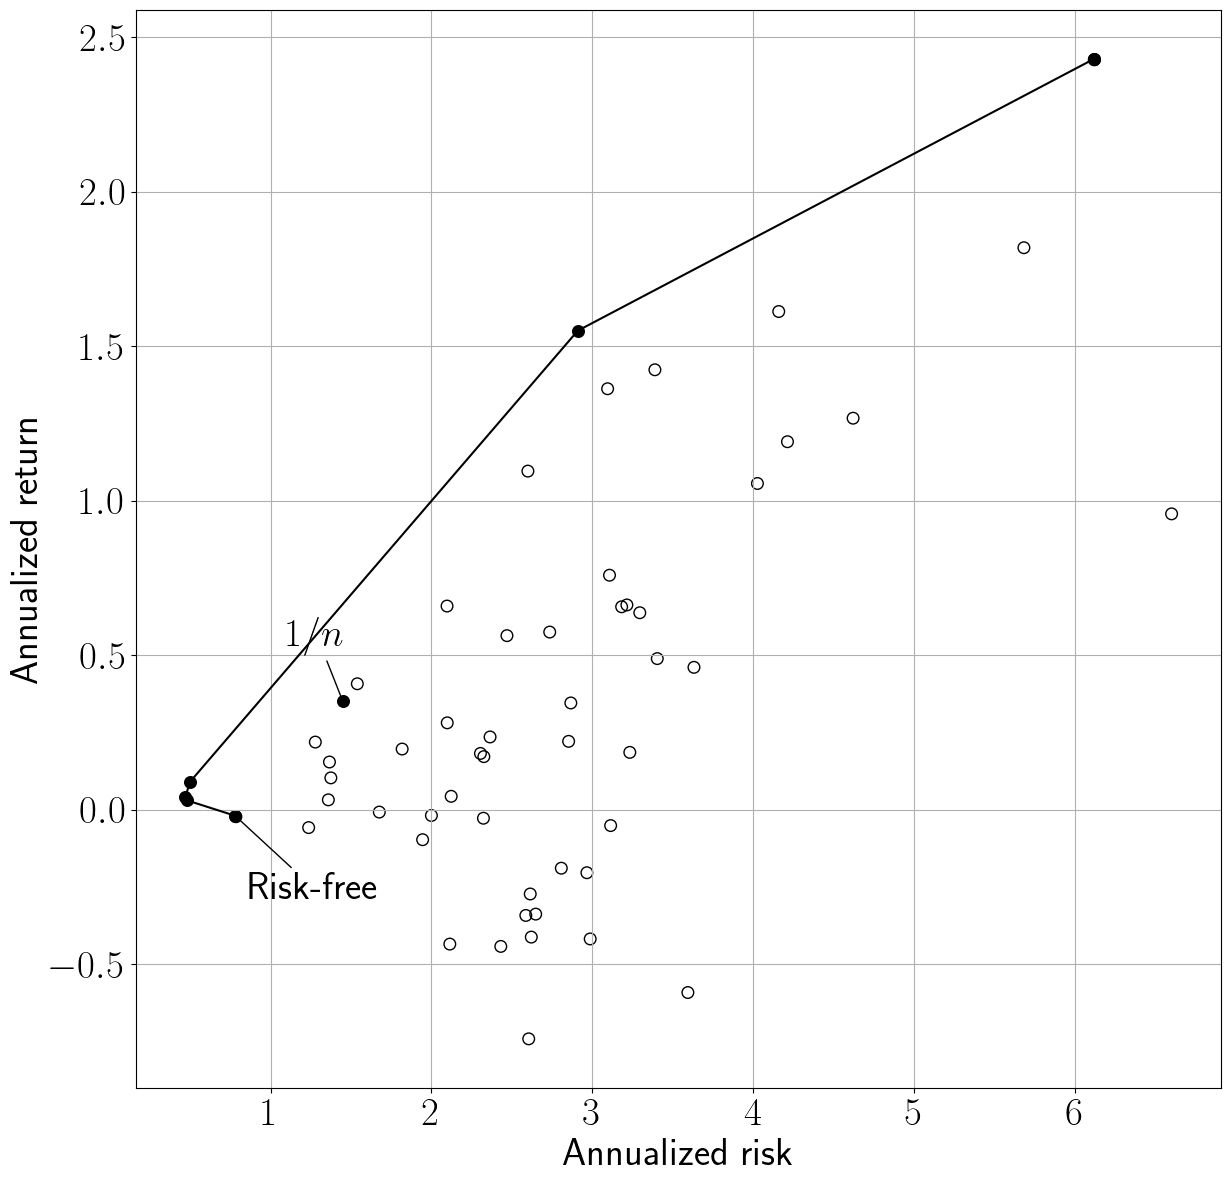

In [29]:
fig, ax = plt.subplots(figsize=(14, 14))
# ax.plot(x_pareto, y_pareto)
ax.scatter(df_individual['risk'], df_individual['return'],  marker='o', s=70, color='k', facecolors='none')
ax.scatter(df_results['Train risk'], df_results['Train return'],  marker='o', s=70, color='k', facecolors='k', clip_on=False)
ax.plot(df_results['Train risk'][:-1], df_results['Train return'][:-1], color="k")

# Annotate risk free and equal investments
ax.annotate(r'Risk-free',
               (df_results['Train risk'][0], df_results['Train return'][0]),
               textcoords="offset points", # how to position the text
               xytext=(10,-60), # distance from text to points (x,y)
               arrowprops=dict(arrowstyle='-', color='k')
              )
ax.annotate(r'$1/n$',
               (df_results['Train risk'][-1], df_results['Train return'][-1]),
               textcoords="offset points", # how to position the text
               xytext=(-40,40), # distance from text to points (x,y)
               arrowprops=dict(arrowstyle='-', color='k')
              )

# ax.set_xlim((0, 0.7))
# ax.set_ylim((-0.1, 0.5))
ax.grid()
ax.set_xlabel("Annualized risk")
ax.set_ylabel("Annualized return")
plt.savefig("pareto_portfolio.pdf")